# Topic Modeling: Cleaning/Pre-Processing

## 1. Import Libraries

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

In [130]:
# import NLP libraries for preprocessing
from nltk.corpus.reader.wordnet import NOUN
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

## 2. Import Data
1. Convert dataframe column with charge descriptions to list.
2. Pad with space (' ') on front and back of each description.

In [131]:
# compas_path = 'compas-scores-two-years.csv'
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
compas_df = pd.read_csv(url)
# sample charge descriptions
compas_df[['c_charge_desc']].head()

,c_charge_desc
0,Aggravated Assault w/Firearm
1,Felony Battery w/Prior Convict
2,Possession of Cocaine
3,Possession of Cannabis
4,arrest case no charge


In [132]:
# get non-NaN charge descriptions as a list
compas_df_charge_filt = compas_df[compas_df['c_charge_desc'].isna() == False]
charge_descs = list(compas_df_charge_filt['c_charge_desc'])
charge_descs = [' ' + desc + ' ' for desc in charge_descs]
print(len(charge_descs))
charge_descs[:10]

7185


[' Aggravated Assault w/Firearm ',
 ' Felony Battery w/Prior Convict ',
 ' Possession of Cocaine ',
 ' Possession of Cannabis ',
 ' arrest case no charge ',
 ' Battery ',
 ' Possession Burglary Tools ',
 ' arrest case no charge ',
 ' Battery ',
 ' Insurance Fraud ']

## 3. Define Word Replacement Mappings

Build dictionary with replacement word and all its mispellings as they appear in charge descriptions.

In [133]:
# make a dictionary with replacement (str) --> mispellings (list of str) mapping
replacement_map = {
    ' accident ': [' acc ', ' accd '],
    ' aggravated ': [' agg ', ' aggr '],
    ' alter ': [' alt '],
    ' ammunition ': [' amm '],
    ' amphetamine ': [' amp '],
    ' attempt ': [' att ', ' attmp '],
    ' attend ': [' attnd '],
    ' battery ': [' batt ', ' bat '],
    ' beverage ': [' bev '],
    ' bodily ': [' bod '],
    ' burglary ': ['burg ', ' burgl '],
    ' business ': [' busn '],
    ' cancel ': [' can '],
    ' counterfeit ': [' cntrft ', ' conterfeit ', ' contrft ', ' countrfeit'],
    ' commit ': [' com '],
    ' communication ': [' communic '],
    ' compensation ': [' compensatn '],
    ' conspiracy ': [' consp '],
    ' control ': [' cont ', ' contr '],
    ' conveyance ': [' conv ', ' conve '],
    ' control ': [' cont ', ' contr '],
    ' convict ': [' convic '],
    ' credit ': [' cred '],
    ' criminal ': [' crim '],
    ' cruelty ': [' crlty '],
    ' custody ': [' cust '],
    ' dangerous ': [' dang '],
    ' degree ': [' deg '],
    ' delinquency ': [' delinq '],
    ' delivery ': [' deliv ', ' del '],
    ' device ': [' dev '],
    ' display ': [' disply '],
    ' disqualified ': [' disqul '],
    ' disorderly conduct ': [' doc '],
    ' dollars ': [' dols '],
    ' d u i ': [' dui '],
    ' domestic ': [' dom ', ' dome '],
    ' drive ': [' driv ', ' drivg '],
    ' dwelling ': [' dwell '],
    ' elderly ': [' elderlly '],
    ' employee ': [' emplyee '],
    ' enforcement ': [' enfor ', ' enforc '],
    ' exhibition ': [' exhib '],
    ' extinguisher ': [' extinquisher '],
    ' facilitate ': [' fac '],
    ' failure ': [' fail '],
    ' family ': [' faml '],
    ' felony ': [' fel '],
    ' felon ': [' felo '],
    ' firearm ': [' f arm '],
    ' fraud ': [' frd ', ' fraudul'],
    ' gambling ': [' gamb '],
    ' gram ': [' g '], # check
    ' great ': [' grt '],
    ' informant ': ['informnt '],
    ' injunction ': [' inj ', ' injunc ', ' injunct ', ' injunctn '],
    ' instrument ': [' inst '],
    ' intent ': [' int '],
    ' interfere ': [' interf '],
    ' introduce ': [' intoduce '],
    ' lascivious ': [' lasc ', ' lasciv '],
    ' lease ': [' leas '],
    ' license ': [' lic ', ' licenc '],
    ' license tag ': [' lictag '],
    ' leave ': [' lve '],
    ' manufacture ': [' man ', ' mfr '],
    ' motor ': [' mot '],
    ' occupied ': [' occup ', ' occp '], # not to confuse with unoccupied -- need space
    ' offense ': [' offens ', ' offn '],
    ' operate ': [' oper ', ' opert '],
    ' permanent ': [' perm '],
    ' person ': [' pers ', ' persn ', ' persnl '],
    ' possession ': [' pos ', ' poss ', ' possess,'],
    ' private ': [' priv '],
    ' promise ': [' promis '],
    ' property ': [' prop '],
    ' public ': [' pub '],
    ' purchase ': [' pur '],
    ' railroad ': [' rail '],
    ' redilver ': [' redeliv '],
    ' revoke ': [' revk '],
    ' scene ': [' scen '],
    ' school ': [' ftsch ', ' scho ', ' scho '],
    ' sell ': [' sel '],
    ' sex ': [' sexual '], # for homogeneity
    ' solicit ': [' solic ', ' solict '],
    ' specialist ': [' speci '],
    ' strangulation ': [' strang '],
    ' structure ': [' struc ', ' struct '],
    ' substance ': [' sub ', ' subst ', ' substa '],
    ' sudden ': [' sudd '],
    ' suspended ': [' susp ', ' suspd '],
    ' traffick ': [' traf ', ' traff ', ' traffic '],
    ' transmit ': [' trans '],
    ' trespass ': [' tresspass '],
    ' trirail ': [' tri rail '], # make 1-wd (tri-rail specific to FLA)
    ' toward ': [' twrd '],
    ' unauthorized ': [' unauth '],
    ' uncovered ': [' uncov '],
    ' unlawful ': [' unl ', ' unlaw '],
    ' unoccupied ': [' unocc ', ' unoccup '],
    ' vehicle ': [' veh '],
    ' victim ': [' vict ', ' victm '],
    ' vehicle identification number ': [' vin '],
    ' violence ': [' viol ', ' vi '],
    ' weapon ': [' weap ', ' wep '],
}

# TODO: decide if these should be utilized (i.e. convert all to full text, or all to abbrevs?)
# make a dictionary with full text (str) --> abbreviation (list of str) mapping
abbrev_map = {
    'law enforcement officer ': ['leo '],
    'driving under influence ': ['dui '],
    'driving while intoxicated ': ['dwi '],
    'driving while license suspended ': ['dwls '],
    'firearm ': ['f arm '],
    'vehicle identification number ': ['vin ']
}

In [134]:
# make a dictionary with replacement (str) --> mispellings (list of str) mapping
r_replacement_map = {
    ' accident ': [' acc ', ' accd '],
    ' aggravated ': [' agg ', ' aggr '],
    ' alcohol ': [' alch '], # NEW
    ' alter ': [' alt '],
    ' ammunition ': [' amm '],
    ' amphetamine ': [' amp '],
    ' attempt ': [' att ', ' attmp '],
    ' attend ': [' attnd '],
    ' battery ': [' batt ', ' bat '],
    ' beverage ': [' bev '],
    ' bodily ': [' bod '],
    ' burglary ': ['burg ', ' burgl '],
    ' business ': [' busn ', ' bus '], # ADDED bus
    ' cancel ': [' can '],
    ' church ': [' chur '], # NEW
    ' counterfeit ': [' cntrft ', ' conterfeit ', ' contrft ', ' countrfeit'],
    ' commit ': [' com '],
    ' communication ': [' communic '],
    ' compensation ': [' compensatn '],
    ' conspiracy ': [' consp '],
    ' control ': [' cont ', ' contr '],
    ' conveyance ': [' conv ', ' conve '],
    ' control ': [' cont ', ' contr '],
    ' convict ': [' convic '],
    ' credit ': [' cred '],
    ' criminal ': [' crim ', ' crimin '], # ADDED crimin
    ' cruelty ': [' crlty '],
    ' custody ': [' cust '],
    ' damage ': [' damg '],
    ' dangerous ': [' dang '],
    ' defendant ': [' deft '], # NEW
    ' degree ': [' deg '],
    ' delinquency ': [' delinq '],
    ' delivery ': [' deliv ', ' del ', ' deliver '], # ADDED deliver
    ' depend ': [' depnd '], # NEW
    ' device ': [' dev '],
    ' display ': [' disply '],
    ' disqualified ': [' disqul '],
    ' disorderly conduct ': [' doc '],
    ' dollars ': [' dols '],
    ' d u i ': [' dui '],
    ' domestic ': [' dom ', ' dome '],
    ' drive ': [' driv ', ' drivg ', ' drv '], # ADDED drv
    ' dwelling ': [' dwell ', ' dwel '], # ADDED dwel
    ' electronic ': [' elec '], # NEW
    ' elderly ': [' elderlly '],
    ' employee ': [' emplyee '],
    ' enforcement ': [' enfor ', ' enforc '],
    ' engage ': [' eng '], # NEW
    ' establishment ': [' estab ', ' establishm '], # NEW
    ' exhibition ': [' exhib '],
    ' extinguisher ': [' extinquisher '],
    ' facilitate ': [' fac '],
    ' failure ': [' fail '],
    ' family ': [' faml '],
    ' felony ': [' fel '],
    ' felon ': [' felo '],
    ' firearm ': [' f arm '],
    ' fraud ': [' frd ', ' fraudul', ' fraud ent '], # ADDED fraud ent
    ' gambling ': [' gamb '],
    ' gram ': [' g '], # check
    ' great ': [' grt '],
    ' hours ': [' hrs '], # NEW
    ' informant ': ['informnt '],
    ' injunction ': [' inj ', ' injunc ', ' injunct ', ' injunctn '],
    ' instrument ': [' inst '],
    ' insurance ': [' insur '], # NEW
    ' intent ': [' int '],
    ' interfere ': [' interf ', ' intrf '], # ADDED intrf
    ' introduce ': [' intoduce '],
    ' lascivious ': [' lasc ', ' lasciv '],
    ' lease ': [' leas '],
    ' license ': [' lic ', ' licenc '],
    ' license tag ': [' lictag '],
    ' leave ': [' lve '],
    ' malicious ': [' malic '], # NEW
    ' manufacture ': [' man ', ' mfr ', ' mfg '], # ADDED mfg
    ' methadone ': [' methado '], # NEW
    ' minor ': [' min '], # NEW
    ' motor ': [' mot '],
    ' obtain ': [' obt '], # NEW
    ' occupied ': [' occup ', ' occp '],
    ' offense ': [' offens ', ' offn '],
    ' operate ': [' oper ', ' opert '],
    ' paraphernalia ': [' para '], # NEW
    ' pedestrian ': [' ped '], # NEW
    ' permanent ': [' perm '],
    ' person ': [' pers ', ' persn ', ' persnl ', ' prson '], # ADDED prson
    ' possession ': [' pos ', ' poss ', ' possess ', ' posses '],
    ' private ': [' priv '],
    ' promise ': [' promis '],
    ' property ': [' prop '],
    ' prostitute ': [' prostitut '], # NEW
    ' prostitution violation ': [' prostitutionviolation '], # NEW
    ' protect ': [' prot '], # NEW
    ' public ': [' pub '],
    ' purchase ': [' pur '],
    ' railroad ': [' rail '],
    ' receipt ': [' rcpt '],
    ' redilver ': [' redeliv '],
    ' registration ': [' reg '], # NEW
    ' responsibility ': [' resp '], # NEW
    ' revoke ': [' revk '],
    ' scene ': [' scen '],
    ' school ': [' ftsch ', ' scho ', ' scho ', ' sch '], # ADDED sch
    ' sell ': [' sel '],
    ' sex ': [' sexual '], # for homogeneity
    ' shop ': [' shp '], # NEW
    ' solicit ': [' solic ', ' solict ', ' sol '], # ADDED sol
    ' specialist ': [' speci '],
    ' strangulation ': [' strang '],
    ' structure ': [' struc ', ' struct '],
    ' substance ': [' sub ', ' subst ', ' substa '],
    ' sudden ': [' sudd '],
    ' suspended ': [' susp ', ' suspd '],
    ' traffick ': [' traf ', ' traff ', ' traffic '],
    ' obstruct traffic ': [' obstruct traffick '], # NEW (acct for traffic/traffick diff)
    ' transmit ': [' trans '],
    ' trespass ': [' tresspass '],
    ' trirail ': [' tri rail '], # make 1-wd (tri-rail specific to FLA)
    ' toward ': [' twrd '],
    ' unauthorized ': [' unauth ', ' unauthorizd '], # ADDED unauthorizd
    ' uncovered ': [' uncov '],
    ' under ': [' und '], # NEW
    ' unlawful ': [' unl ', ' unlaw '],
    ' unoccupied ': [' unocc ', ' unoccup '],
    ' vehicle ': [' veh '],
    ' verification ': [' verif '], # NEW
    ' victim ': [' vict ', ' victm '],
    ' vehicle identification number ': [' vin '],
    ' violence ': [' viol ', ' vi '],
    ' weapon ': [' weap ', ' wep '],
    ' witness ': [' wit '], # NEW
    ' years ': [' yrs '] # NEW
}

# TODO: decide if these should be utilized (i.e. convert all to full text, or all to abbrevs?)
# make a dictionary with full text (str) --> abbreviation (list of str) mapping
abbrev_map = {
    'law enforcement officer ': ['leo '],
    'driving under influence ': ['dui '],
    'driving while intoxicated ': ['dwi '],
    'driving while license suspended ': ['dwls '],
    'firearm ': ['f arm '],
    'vehicle identification number ': ['vin ']
}

## 4. Define Pre-processing Functions
1. **get_chars_to_rmv:** Get list of non-alpha characters and replace with space
2. **check_desc:** Get charge description containing a certain token (for reference).
3. **clean_descs:** Remove chars_to_rmv; replace mispellings and remove any excess whitespace.
4. **tokenize_descs:** Tokenize descriptions.
5. **stem_tokens:** Stem each token in each description (exclude English stop words and tokens < 3 chars in length).

In [135]:
# build a list of non-alpha chars to remove, which can be fed into a replacement function as a regex
def get_chars_to_rmv(charge_descs):
    chars=[]
    for d in charge_descs:
        for t in d:
            for c in t:
                if not c.isalpha() and c not in chars:
                    chars.append(c)
    chars_to_rmv = ''.join(sorted(chars)).strip()
    chars_to_rmv = '[' + chars_to_rmv + ']'
    return chars_to_rmv

In [136]:
# REMOVE WHEN DONE -- simply for checking full description of confusing tokens for context
def check_desc(keyword):
    for d in charge_descs:
        if keyword in d.lower():
            print(d)

In [137]:
def clean_descs(chars_to_rmv, charge_descs, replacement_map):
    # remove non-alpha characters
    charge_descs_clean = [re.sub(chars_to_rmv, ' ', desc.lower()) for desc in charge_descs]
    # replace mispellings using replacement_map
    for repl, mispellings in replacement_map.items():
        for misp in mispellings:
            charge_descs_clean = [re.sub(misp, repl, desc) for desc in charge_descs_clean]

    # remove extra spaces
    charge_descs_clean = [re.sub(' +', ' ', desc) for desc in charge_descs_clean]
    return charge_descs_clean

In [138]:
def tokenize_descs(charge_descs_clean):
    # use nltk tokenizer to tokenize each description
    tokenized_descs = [word_tokenize(desc.lower()) for desc in charge_descs_clean]
    # sample of tokenized descriptions
    return tokenized_descs

In [139]:
def stem_tokens(tokenized_descs):
    # make stemmer
    stemmer = SnowballStemmer(language='english')

    # get english stop words
    swds = stopwords.words('english')

    # list for toring tokenized & stemmed descriptions
    tokenized_stemmed = []
    # list for storing stemmed/token/description triplets
    stem_token_descs = []

    # stem each token in each description
    for desc in tokenized_descs:
        stemmed = [(stemmer.stem(token)) for token in desc if (len(token) > 2 and token not in swds)]
        tokenized_stemmed.append(stemmed)
        # also build a list containing stemmed token, original token, and the description it came from 
        # (for reference and debugging purposes)
        triplet = [(stemmer.stem(token), token, ' '.join(desc)) for token in desc if len(token) > 2]
        stem_token_descs.append(triplet)
    return tokenized_stemmed

## 5. Preprocess First Charge Descriptions

In [140]:
chars_to_rmv = get_chars_to_rmv(charge_descs)
chars_to_rmv

'[#$()+,-./0123456789<>]'

In [141]:
# clean descriptions
charge_descs_clean = clean_descs(chars_to_rmv, charge_descs, r_replacement_map)
# sample of cleaned charge descriptions
charge_descs_clean[:20]

[' aggravated assault w firearm ',
 ' felony battery w prior convict ',
 ' possession of cocaine ',
 ' possession of cannabis ',
 ' arrest case no charge ',
 ' battery ',
 ' possession burglary tools ',
 ' arrest case no charge ',
 ' battery ',
 ' insurance fraud ',
 ' possession mdma ecstasy ',
 ' battery ',
 ' battery ',
 ' possession methylenedioxymethcath ',
 ' arrest case no charge ',
 ' felony driving while license suspended ',
 ' battery ',
 ' grand theft in the rd degree ',
 ' driving while license revoked ',
 ' possession of heroin ']

In [142]:
# tokenize
tokenized_descs = tokenize_descs(charge_descs_clean)
# sample of tokenized descriptions
tokenized_descs[:10]

[['aggravated', 'assault', 'w', 'firearm'],
 ['felony', 'battery', 'w', 'prior', 'convict'],
 ['possession', 'of', 'cocaine'],
 ['possession', 'of', 'cannabis'],
 ['arrest', 'case', 'no', 'charge'],
 ['battery'],
 ['possession', 'burglary', 'tools'],
 ['arrest', 'case', 'no', 'charge'],
 ['battery'],
 ['insurance', 'fraud']]

In [143]:
# stem and remove stopwords
tokenized_stemmed = stem_tokens(tokenized_descs)
tokenized_stemmed = [', '.join(desc) for desc in tokenized_stemmed]
# sample of stemmed, tokenized descriptions
print(tokenized_stemmed[:10])

# make sorted list of unique tokens (vocabulary)
flat_unq_tokens = sorted(set([token for desc in tokenized_stemmed for token in desc.split(', ')]))
print('\nnumber of unique tokens (vocab length):', len(flat_unq_tokens))
print('number of unique charge descriptions:', len(set([' '.join(desc) for desc in tokenized_stemmed])))

# sample of stemmed, tokenized descriptions
flat_unq_tokens[:10]

['aggrav, assault, firearm', 'feloni, batteri, prior, convict', 'possess, cocain', 'possess, cannabi', 'arrest, case, charg', 'batteri', 'possess, burglari, tool', 'arrest, case, charg', 'batteri', 'insur, fraud']

number of unique tokens (vocab length): 421
number of unique charge descriptions: 406


['abet',
 'abus',
 'accessori',
 'accid',
 'act',
 'actual',
 'adult',
 'aggrav',
 'aggress',
 'agre']

In [144]:
d = {'id': compas_df_charge_filt['id'], 'name': compas_df_charge_filt['name'], 'charge description': compas_df_charge_filt['c_charge_desc'], 
     'tokenized_stemmed description': tokenized_stemmed}
charge_mappings = pd.DataFrame(data=d)

In [145]:
charge_mappings.head()

,id,name,charge description,tokenized_stemmed description
0,1,miguel hernandez,Aggravated Assault w/Firearm,"aggrav, assault, firearm"
1,3,kevon dixon,Felony Battery w/Prior Convict,"feloni, batteri, prior, convict"
2,4,ed philo,Possession of Cocaine,"possess, cocain"
3,5,marcu brown,Possession of Cannabis,"possess, cannabi"
4,6,bouthy pierrelouis,arrest case no charge,"arrest, case, charg"


## Preprocessing Second Charge Descriptions

In [146]:
# get non-NaN r_charge descriptions as a list
r_compas_df_charge_filt = compas_df[compas_df['r_charge_desc'].isna() == False]
r_charge_descs = list(r_compas_df_charge_filt['r_charge_desc'])
r_charge_descs = [' ' + desc + ' ' for desc in r_charge_descs]
print(len(r_charge_descs))
r_charge_descs[:10]

3413


[' Felony Battery (Dom Strang) ',
 ' Driving Under The Influence ',
 ' Poss of Firearm by Convic Felo ',
 ' Battery ',
 ' Driving License Suspended ',
 ' Grand Theft (Motor Vehicle) ',
 ' Criminal Mischief>$200<$1000 ',
 ' Grand Theft in the 3rd Degree ',
 ' Possession of Cocaine ',
 ' Poss Cocaine/Intent To Del/Sel ']

In [147]:
# get chars to remove from r crimes
r_chars_to_rmv = get_chars_to_rmv(r_charge_descs)
r_chars_to_rmv

'["$()+,-./0123456789<>]'

In [148]:
# sample of cleaned charge descriptions
r_charge_descs_clean = clean_descs(r_chars_to_rmv, r_charge_descs, r_replacement_map)
# sample of cleaned charge descriptions
r_charge_descs_clean[:20]

[' felony battery domestic strangulation ',
 ' driving under the influence ',
 ' possession of firearm by convict felon ',
 ' battery ',
 ' driving license suspended ',
 ' grand theft motor vehicle ',
 ' criminal mischief ',
 ' grand theft in the rd degree ',
 ' possession of cocaine ',
 ' possession cocaine intent to delivery sell ',
 ' prowling loitering ',
 ' operating w o valid license ',
 ' possession cannabis grams or less ',
 ' driving license suspended ',
 ' possession cannabis grams or less ',
 ' false imprisonment ',
 ' grand theft motor vehicle ',
 ' resist obstruct w o violence ',
 ' possession cannabis grams or less ',
 ' grand theft in the rd degree ']

In [149]:
# tokenize each description
r_tokenized_descs = tokenize_descs(r_charge_descs_clean)
# sample of tokenized descriptions
r_tokenized_descs[:10]

[['felony', 'battery', 'domestic', 'strangulation'],
 ['driving', 'under', 'the', 'influence'],
 ['possession', 'of', 'firearm', 'by', 'convict', 'felon'],
 ['battery'],
 ['driving', 'license', 'suspended'],
 ['grand', 'theft', 'motor', 'vehicle'],
 ['criminal', 'mischief'],
 ['grand', 'theft', 'in', 'the', 'rd', 'degree'],
 ['possession', 'of', 'cocaine'],
 ['possession', 'cocaine', 'intent', 'to', 'delivery', 'sell']]

In [150]:
# stem each token in each description & remove stop words
r_tokenized_stemmed = stem_tokens(r_tokenized_descs)
r_tokenized_stemmed = [', '.join(desc) for desc in r_tokenized_stemmed]
# sample of stemmed, tokenized descriptions
print(r_tokenized_stemmed[:10])

['feloni, batteri, domest, strangul', 'drive, influenc', 'possess, firearm, convict, felon', 'batteri', 'drive, licens, suspend', 'grand, theft, motor, vehicl', 'crimin, mischief', 'grand, theft, degre', 'possess, cocain', 'possess, cocain, intent, deliveri, sell']


In [151]:
d = {'id': r_compas_df_charge_filt['id'], 'name': r_compas_df_charge_filt['name'], 
     'charge description': r_compas_df_charge_filt['r_charge_desc'], 
     'r_tokenized_stemmed description': r_tokenized_stemmed}
r_charge_mappings = pd.DataFrame(data=d)
r_charge_mappings

,id,name,charge description,r_tokenized_stemmed description
1,3,kevon dixon,Felony Battery (Dom Strang),"feloni, batteri, domest, strangul"
2,4,ed philo,Driving Under The Influence,"drive, influenc"
6,8,edward riddle,Poss of Firearm by Convic Felo,"possess, firearm, convict, felon"
9,13,bo bradac,Battery,batteri
11,15,ellyaher lanza,Driving License Suspended,"drive, licens, suspend"
...,...,...,...,...
7201,10985,kyle miller,Operating W/O Valid License,"oper, valid, licens"
7205,10990,christopher tun,Assault,assault
7206,10992,alexander vega,Possess Cannabis/20 Grams Or Less,"possess, cannabi, gram, less"
7207,10994,jarred payne,Possession of Cannabis,"possess, cannabi"


## Prepare for Common Token Analysis / Visualization

In [152]:
# check lengths of df slices before merge
print('# rows total:', len(compas_df))
print('# rows where c_charge is non-NaN:', len(charge_mappings))
print('# rows where r_charge is non-NaN:', len(r_charge_mappings))
# get df rows where c_charge and r_charge both non-NaN
cr_idx = (compas_df['c_charge_desc'].isna() == False) & (compas_df['r_charge_desc'].isna() == False)
print('# rows where c_charge and r_charge both non-NaN:', len(cr_idx[cr_idx == True]))

# rows total: 7214
# rows where c_charge is non-NaN: 7185
# rows where r_charge is non-NaN: 3413
# rows where c_charge and r_charge both non-NaN: 3393


In [153]:
c_df_merged = compas_df.merge(charge_mappings[['id', 'tokenized_stemmed description']], how='outer', on='id')

In [154]:
cr_df_merged = c_df_merged.merge(r_charge_mappings[['id', 'r_tokenized_stemmed description']], how='outer', on='id')

In [155]:
merged_filt = cr_df_merged[['id', 'name', 'race', 'c_charge_desc', 'tokenized_stemmed description', 'two_year_recid', 'r_charge_desc', 'r_tokenized_stemmed description']]
merged_filt.head()

,id,name,race,c_charge_desc,tokenized_stemmed description,two_year_recid,r_charge_desc,r_tokenized_stemmed description
0,1,miguel hernandez,Other,Aggravated Assault w/Firearm,"aggrav, assault, firearm",0,NaN,NaN
1,3,kevon dixon,African-American,Felony Battery w/Prior Convict,"feloni, batteri, prior, convict",1,Felony Battery (Dom Strang),"feloni, batteri, domest, strangul"
2,4,ed philo,African-American,Possession of Cocaine,"possess, cocain",1,Driving Under The Influence,"drive, influenc"
3,5,marcu brown,African-American,Possession of Cannabis,"possess, cannabi",0,NaN,NaN
4,6,bouthy pierrelouis,Other,arrest case no charge,"arrest, case, charg",0,NaN,NaN


In [156]:
merged_filt.to_csv('merged_filt_NEW.csv')

## LDA Model Building: Implemented based on Gensim Documentation examples
https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py

In [124]:
# import topic modeling libraries
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [26]:
def visualize_model(model, corpus, dictionary):
    return pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)

In [19]:
# create a dictionary representation of documents (charge descriptions)
tokenized_stemmed = stem_tokens(tokenized_descs)
dictionary = Dictionary(tokenized_stemmed)

# dictionary.filter_extremes(no_below=3, no_above=0.5)

# create a BoW representation of the documents
corpus = [dictionary.doc2bow(desc) for desc in tokenized_stemmed]

In [20]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 428
Number of documents: 7185


In [54]:
# Set up log to terminal: https://miningthedetails.com/blog/python/lda/GensimLDA/
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Supress default INFO logging

#import logging
#logger = logging.getLogger()
#logger.setLevel(logging.CRITICAL)

In [23]:
# NOTE: set random seed
# set training parameters 
num_topics = 5
chunksize = 10000
passes = 20
iterations = 400
eval_every = 1

temp = dictionary[0]
id2word = dictionary.id2token

# build model
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [80]:
top_topics = model.top_topics(corpus)
avg_topic_coher = sum(t[1] for t in top_topics) / num_topics

print('Average topic coherence: %.4f.' % avg_topic_coher)

#pprint(top_topics)

Average topic coherence: -19.5958.


In [27]:
visualize_model(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.248000 -0.123399       1        1  18.165289
1      0.278194  0.002663       2        1  18.704818
2      0.279709 -0.027695       3        1  19.721858
3     -0.155911  0.385750       4        1  22.629155
4     -0.153993 -0.237319       5        1  20.778881, topic_info=       Term         Freq        Total Category  logprob  loglift
3   batteri  1593.000000  1593.000000  Default  30.0000  30.0000
10   arrest  1105.000000  1105.000000  Default  29.0000  29.0000
12    charg  1105.000000  1105.000000  Default  28.0000  28.0000
11     case  1104.000000  1104.000000  Default  27.0000  27.0000
8   possess  1202.000000  1202.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
48  attempt    28.365148    53.918870   Topic5  -4.9621   0.9289
5    feloni    66.661772   363.842429   Topic5  -4.1077  -0.1259
25    theft    76.501954   666.734245   Topic5  -3.9700  -0.5938
55   weapon    50.233395   235.558953   Topic5  -4.3906   0.0260
73   vehicl    41.008905   215.428398   Topic5  -4.5935  -0.0876

[227 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
126       2  0.953500     abus
123       5  0.985572    accid
266       3  0.940180      act
0         2  0.580793   aggrav
0         3  0.417269   aggrav
...     ...       ...      ...
65        4  0.208524  violenc
55        3  0.785366   weapon
55        5  0.212261   weapon
167       2  0.953500      wit
190       2  0.769337      yrs

[214 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [328]:
# train second LDA model

# set training parameters 
num_topics = 5
chunksize = 10000
passes = 20
iterations = 400
eval_every = 1

temp = dictionary[0]
id2word = dictionary.id2token

model2 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=25
)

In [28]:
pprint(model.print_topics())

[(0,
  '0.166*"theft" + 0.152*"grand" + 0.124*"degre" + 0.062*"violenc" + '
  '0.039*"deliveri" + 0.037*"intent" + 0.036*"sell" + 0.030*"cannabi" + '
  '0.030*"vehicl" + 0.030*"possess"'),
 (1,
  '0.437*"batteri" + 0.056*"aggrav" + 0.054*"feloni" + 0.040*"drive" + '
  '0.038*"influenc" + 0.028*"domest" + 0.027*"strangul" + 0.021*"tamper" + '
  '0.020*"harm" + 0.020*"deliv"'),
 (2,
  '0.129*"licens" + 0.097*"drive" + 0.086*"burglari" + 0.063*"suspend" + '
  '0.056*"revok" + 0.056*"unoccupi" + 0.049*"assault" + 0.048*"weapon" + '
  '0.045*"dead" + 0.039*"aggrav"'),
 (3,
  '0.250*"arrest" + 0.250*"charg" + 0.250*"case" + 0.027*"offic" + '
  '0.015*"vehicl" + 0.014*"level" + 0.013*"law" + 0.013*"minor" + '
  '0.013*"violenc" + 0.013*"resist"'),
 (4,
  '0.271*"possess" + 0.131*"cocain" + 0.050*"cannabi" + 0.030*"petit" + '
  '0.030*"damag" + 0.028*"properti" + 0.027*"gram" + 0.024*"less" + '
  '0.019*"theft" + 0.019*"injuri"')]


In [167]:
def topic_distr_to_cols(model, tokenized_docs):
    topics = [model.get_document_topics(dictionary.doc2bow(doc), minimum_probability=0) for doc in tokenized_docs]
    rows = [[topic_distr[i][1] for i in range(len(topic_distr))] for topic_distr in topics]
    columns = [[row[i] for row in rows] for i in range(len(row))] 
    return columns
    
def get_max_topics(model, tokenized_docs):
    topics = [model.get_document_topics(dictionary.doc2bow(doc), minimum_probability=0) for doc in tokenized_docs]
    rows = [[topic_distr[i][1] for i in range(len(topic_distr))] for topic_distr in topics]
    max_topics = [np.argmax(row) + 1 for row in rows]
    return max_topics

### Create Topic Distribution Dataframe for First Offense Charge Descriptions

In [166]:
tokenized_stemmed = stem_tokens(tokenized_descs)
cols = topic_distr_to_cols(model, tokenized_stemmed)
max_topics = get_max_topics(model, tokenized_stemmed)
d = {
     'id': compas_df_charge_filt['id'], 
     'name': compas_df_charge_filt['name'], 
     'race': compas_df_charge_filt['name'], 
     'charge description': compas_df_charge_filt['c_charge_desc'], 
     'tokenized description': tokenized_stemmed,
     'max topic': max_topics, 
     't1': cols[0], 't2': cols[1], 't3': cols[2], 't4': cols[3], 't5': cols[4]}
compas_df_topics = pd.DataFrame(data=d)
compas_df_topics

[0.02523719, 0.88318557, 0.027123129, 0.031303093, 0.033150993]


,id,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
0,1,miguel hernandez,miguel hernandez,Aggravated Assault w/Firearm,"[aggrav, assault, firearm]",2,0.025237,0.883186,0.027123,0.031303,0.033151
1,3,kevon dixon,kevon dixon,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",2,0.019687,0.908891,0.021150,0.024409,0.025863
2,4,ed philo,ed philo,Possession of Cocaine,"[possess, cocain]",5,0.035144,0.052206,0.037754,0.043574,0.831321
3,5,marcu brown,marcu brown,Possession of Cannabis,"[possess, cannabi]",5,0.035146,0.052206,0.037754,0.043574,0.831319
4,6,bouthy pierrelouis,bouthy pierrelouis,arrest case no charge,"[arrest, case, charg]",4,0.025237,0.037489,0.027111,0.877013,0.033151
...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven butler,Deliver Cannabis,"[deliveri, cannabi]",1,0.820242,0.052206,0.037754,0.043574,0.046224
7210,10997,malcolm simmons,malcolm simmons,Leaving the Scene of Accident,"[leav, scene, accid]",5,0.025237,0.037489,0.027111,0.031291,0.878872
7211,10999,winston gregory,winston gregory,Aggravated Battery / Pregnant,"[aggrav, batteri, pregnant]",2,0.025237,0.883209,0.027113,0.031290,0.033151
7212,11000,farrah jean,farrah jean,Battery on Law Enforc Officer,"[batteri, law, enforc, offic]",4,0.019687,0.249165,0.021149,0.684139,0.025861


In [86]:
# check c_charge_desc against r_charge_desc
idx = compas_df['r_charge_desc'].isna() == False
compas_df.loc[idx][['name','c_charge_desc','r_charge_desc']]

,name,c_charge_desc,r_charge_desc
1,kevon dixon,Felony Battery w/Prior Convict,Felony Battery (Dom Strang)
2,ed philo,Possession of Cocaine,Driving Under The Influence
6,edward riddle,Possession Burglary Tools,Poss of Firearm by Convic Felo
9,bo bradac,Insurance Fraud,Battery
11,ellyaher lanza,Battery,Driving License Suspended
...,...,...,...
7201,kyle miller,Possession of Cocaine,Operating W/O Valid License
7205,christopher tun,arrest case no charge,Assault
7206,alexander vega,Grand Theft (Motor Vehicle),Possess Cannabis/20 Grams Or Less
7207,jarred payne,Possess Cannabis/20 Grams Or Less,Possession of Cannabis


### Create Topic Distribution Dataframe for Second Offense Charge Descriptions

In [168]:
r_tokenized_stemmed = stem_tokens(r_tokenized_descs)
r_cols = topic_distr_to_cols(model, r_tokenized_stemmed)
r_max_topics = get_max_topics(model, r_tokenized_stemmed)
d = {
     'id': r_compas_df_charge_filt['id'], 
     'name': r_compas_df_charge_filt['name'], 
     'race': r_compas_df_charge_filt['race'], 
     'charge description': r_compas_df_charge_filt['c_charge_desc'], 
     'tokenized desc': r_tokenized_stemmed,
     'max topic': r_max_topics, 
     't1': r_cols[0], 't2': r_cols[1], 't3': r_cols[2], 't4': r_cols[3], 't5': r_cols[4]
    }
r_compas_df_topics = pd.DataFrame(data=d)
r_compas_df_topics[:10]

,id,name,race,charge description,tokenized desc,max topic,t1,t2,t3,t4,t5
1,3,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, domest, strangul]",2,0.019687,0.908891,0.021150,0.024409,0.025863
2,4,ed philo,African-American,Possession of Cocaine,"[drive, influenc]",2,0.035144,0.837351,0.037766,0.043574,0.046165
6,8,edward riddle,Caucasian,Possession Burglary Tools,"[possess, firearm, convict, felon]",2,0.019688,0.469167,0.021150,0.024426,0.465570
9,13,bo bradac,Caucasian,Insurance Fraud,[batteri],2,0.057858,0.732249,0.062155,0.071737,0.076001
11,15,ellyaher lanza,African-American,Battery,"[drive, licens, suspend]",3,0.025237,0.037505,0.872817,0.031290,0.033151
14,19,craig gilbert,Caucasian,arrest case no charge,"[grand, theft, motor, vehicl]",1,0.899330,0.029244,0.021149,0.024412,0.025864
15,20,samuel seraphin,African-American,Felony Driving While Lic Suspd,"[crimin, mischief]",5,0.035144,0.052206,0.037757,0.043575,0.831318
18,23,neil heckart,Caucasian,Driving While License Revoked,"[grand, theft, degre]",1,0.870958,0.037489,0.027111,0.031290,0.033152
19,24,michael lux,Caucasian,Possession Of Heroin,"[possess, cocain]",5,0.035144,0.052206,0.037754,0.043574,0.831321
20,25,columbus wilson,African-American,arrest case no charge,"[possess, cocain, intent, deliveri, sell]",1,0.587760,0.023973,0.017336,0.020009,0.350922


## Visualization

In [210]:
def compute_avg_point(xs, ys):
    avg_x = np.sum(xs)/len(xs)
    avg_y = np.sum(ys)/len(ys)
    return (avg_x, avg_y)

In [228]:
# display topic-topic scatter plot given races, dims
def display_scatter(df, races, dim1, dim2, colors, xlab, ylab, title):
    df_filt = [df[df['race'] == race] for race in races]
    
    # scatter by race
    for i in range(len(df_filt)):
        xs = df_filt[i][dim1]
        ys = df_filt[i][dim2]
        plt.scatter(x=xs,y=ys,c=colors[races[i]][0],label=races[i])
        avg = compute_avg_point(xs, ys)
        avg_rd = (round(avg[0], 3), round(avg[1], 3))
        plt.scatter(x=avg[0],y=avg[1],c=colors[races[i]][1],label=races[i] + ' Avg.: ' + str(avg_rd))
    
    # add fig axes/legend/title
    plt.legend(title='Race')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()

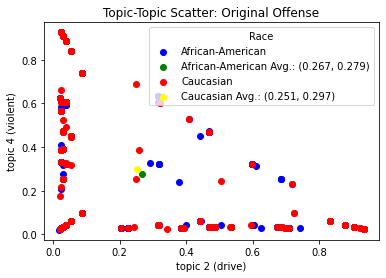

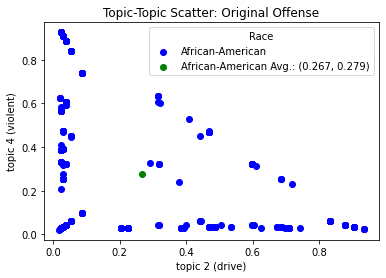

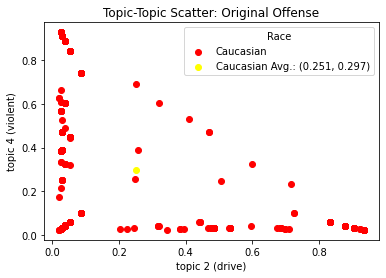

In [343]:
colors = {'African-American':['blue', 'green'], 'Caucasian':['red', 'yellow']}
display_scatter(compas_df_topics, ['African-American', 'Caucasian'], 't3', 't5', colors, 'topic 2 (drive)', 'topic 4 (violent)', 'Topic-Topic Scatter: Original Offense')
display_scatter(compas_df_topics, ['African-American'], 't3', 't5', colors, 'topic 2 (drive)', 'topic 4 (violent)', 'Topic-Topic Scatter: Original Offense')
display_scatter(compas_df_topics, ['Caucasian'], 't3', 't5', colors, 'topic 2 (drive)', 'topic 4 (violent)', 'Topic-Topic Scatter: Original Offense')

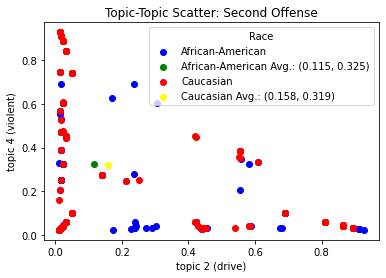

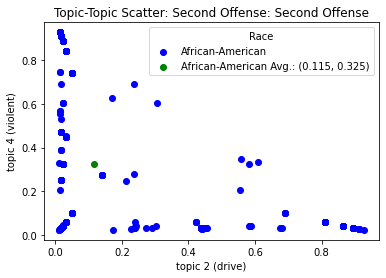

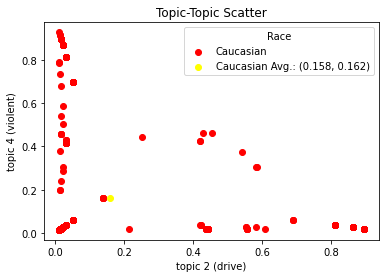

In [344]:
colors = {'African-American':['blue', 'green'], 'Caucasian':['red', 'yellow']}
display_scatter(r_compas_df_topics, ['African-American', 'Caucasian'], 't2', 't4', colors, 'topic 2 (drive)', 'topic 4 (violent)', 'Topic-Topic Scatter: Second Offense')
display_scatter(r_compas_df_topics, ['African-American'], 't2', 't4', colors, 'topic 2 (drive)', 'topic 4 (violent)', 'Topic-Topic Scatter: Second Offense: Second Offense')
display_scatter(r_compas_df_topics, ['Caucasian'], 't2', 't5', colors, 'topic 2 (drive)', 'topic 4 (violent)', 'Topic-Topic Scatter')